In [1]:
# Reddit Cost-of-Living & Market Sentiment – Milestone 2 (NLP)

This notebook extends our Milestone 1 exploratory analysis with:

- External data: daily stock prices for selected tickers (NVDA, AAPL, SPY)  
- NLP preprocessing of Reddit submissions (tokenization, normalization, stopwords, lemmatization, stemming)  
- Regex-based topic flags (housing vs. jobs/income posts)  
- Sentiment scoring of posts with SparkNLP  
- Summary tables and visualizations connecting Reddit chatter to external market data

The notebook uses the **sample Reddit JSONs** from `data/raw` for development.  
The same pipeline can later be run on the filtered parquet data in the cloud.

SyntaxError: invalid syntax (2857210738.py, line 3)

In [1]:
import importlib
import sys
import subprocess

required_packages = {
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "pyspark": "pyspark",
    "sparknlp": "sparknlp",
    "seaborn": "seaborn",
    "numpy": "numpy"
}

def install(pkg):
    """Install a Python package using pip."""
    print(f"📦 Installing missing package: {pkg} ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# --- Check for modules and install missing ones ---
for module_name, pip_name in required_packages.items():
    try:
        importlib.import_module(module_name)
        print(f"✅ {module_name} is installed.")
    except ImportError:
        print(f"❌ {module_name} is missing.")
        install(pip_name)

# --- Show versions ---
print("\n🔍 Environment summary:")
for module_name in required_packages:
    try:
        mod = importlib.import_module(module_name)
        print(f" - {module_name}: {mod.__version__}")
    except:
        print(f" - {module_name}: NOT FOUND")

✅ pandas is installed.
✅ matplotlib is installed.
✅ pyspark is installed.
✅ sparknlp is installed.
✅ seaborn is installed.
✅ numpy is installed.

🔍 Environment summary:
 - pandas: 2.3.3
 - matplotlib: 3.10.7
 - pyspark: 3.5.1
 - sparknlp: NOT FOUND
 - seaborn: 0.13.2
 - numpy: 2.2.6


In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F, types as T

import sparknlp
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import (
    Tokenizer,
    Normalizer,
    LemmatizerModel,
    StopWordsCleaner,
    Stemmer,
    SentimentDLModel,
)

%matplotlib inline

# ---------- Paths ----------
# Notebook lives in code/nlp/, repo root is two levels up
REPO_ROOT = Path.cwd().parents[1]
DATA_RAW = REPO_ROOT / "data" / "raw"
DATA_PROCESSED = REPO_ROOT / "data" / "processed"
IMG_DIR = REPO_ROOT / "img"

DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

print("Repo root:", REPO_ROOT)
print("Raw data:", DATA_RAW)
print("Processed data:", DATA_PROCESSED)

# ---------- Spark with SparkNLP ----------
print("SparkNLP version:", sparknlp.version())

spark = sparknlp.start()  # uses the pyspark in this env
print("Spark version:", spark.version)

spark

Repo root: /Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project
Raw data: /Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project/data/raw
Processed data: /Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project/data/processed
SparkNLP version: 5.4.2
:: loading settings :: url = jar:file:/opt/anaconda3/envs/dsan6000/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/stevengao/.ivy2/cache
The jars for the packages stored in: /Users/stevengao/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f961faf1-7f67-4714-a570-3c0625ec0273;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.4.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 i

Spark version: 3.5.1


In [3]:
# Load the same sample JSONs used in Milestone 1
submissions_sdf = spark.read.json(str(DATA_RAW / "submissions-sample.json"))
comments_sdf = spark.read.json(str(DATA_RAW / "comments-sample.json"))

print("Submissions rows:", submissions_sdf.count())
print("Comments rows:", comments_sdf.count())

# Keep only columns we actually need
submissions_sdf = submissions_sdf.select(
    "id",
    "subreddit",
    "created_utc",
    "title",
    "selftext",
    "score",
    "num_comments",
)

comments_sdf = comments_sdf.select(
    "id",
    "link_id",
    "subreddit",
    "created_utc",
    "body",
    "score",
)

submissions_sdf.printSchema()
comments_sdf.printSchema()

# Combine title + selftext into a single text field
submissions_sdf = submissions_sdf.withColumn(
    "text",
    F.concat_ws(" ", F.col("title"), F.col("selftext"))
)

submissions_sdf.select("subreddit", "title", "selftext", "text").show(5, truncate=80)

25/11/14 19:23:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Submissions rows: 1000
Comments rows: 10000
root
 |-- id: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)

root
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- body: string (nullable = true)
 |-- score: long (nullable = true)

+--------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|           subreddit|                                                                           title|                                                                        selftex

In [4]:
import sys
from importlib import import_module

# Make sure the repo's code/ directory is on sys.path
code_dir = REPO_ROOT / "code"
if str(code_dir) not in sys.path:
    sys.path.append(str(code_dir))

# Try to import your helper module
try:
    spd = import_module("stock_price_downloader")
    print("Imported stock_price_downloader from:", spd.__file__)
except ImportError as e:
    print("ERROR: Could not import stock_price_downloader:", e)
    raise

# Path where a combined CSV *would* be saved by stock_price_downloader
stocks_path = DATA_RAW / "combined_stocks_2022-01-01_to_2023-03-31.csv"

if stocks_path.exists():
    print("Found existing combined stocks file:", stocks_path)
    stocks_df = pd.read_csv(stocks_path)
    print("Rows:", len(stocks_df))
else:
    print("No combined stocks file found – downloading via yfinance...")
    tickers = ["NVDA", "AAPL", "MSFT", "SPY"]
    stocks_df = spd.download_multiple_stocks(
        tickers,
        "2022-01-01",
        "2023-03-31",
        save_combined=True,
        save_individual=True,
        verbose=True,
    )

stocks_df.head()

Imported stock_price_downloader from: /Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project/code/stock_price_downloader.py
Found existing combined stocks file: /Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project/data/raw/combined_stocks_2022-01-01_to_2023-03-31.csv
Rows: 1248


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Capital Gains
0,2022-01-03 00:00:00-05:00,29.759015,30.653332,29.729070,30.064440,391547000,0.0,0.0,NVDA,NaN
1,2022-01-04 00:00:00-05:00,30.220151,30.410792,28.295771,29.235004,527154000,0.0,0.0,NVDA,NaN
2,2022-01-05 00:00:00-05:00,28.894638,29.360762,27.481298,27.552164,498064000,0.0,0.0,NVDA,NaN
3,2022-01-06 00:00:00-05:00,27.588100,28.384602,27.014181,28.125090,454186000,0.0,0.0,NVDA,NaN
4,2022-01-07 00:00:00-05:00,28.088157,28.368630,27.006191,27.195835,409939000,0.0,0.0,NVDA,NaN


In [5]:
# Text length in characters and simple word count
submissions_sdf = submissions_sdf.withColumn("text_len_chars", F.length("text"))
submissions_sdf = submissions_sdf.withColumn(
    "text_len_words",
    F.size(F.split(F.col("text"), r"\s+"))
)

length_summary = submissions_sdf.agg(
    F.expr("percentile(text_len_words, array(0.25, 0.5, 0.75)) as word_len_quantiles"),
    F.avg("text_len_words").alias("avg_words"),
    F.max("text_len_words").alias("max_words"),
)

length_summary.show(truncate=False)

# Bucket by length for a summary table
submissions_sdf = submissions_sdf.withColumn(
    "length_bucket",
    F.when(F.col("text_len_words") < 30, "short")
     .when(F.col("text_len_words") < 100, "medium")
     .otherwise("long")
)

length_bucket_counts = (
    submissions_sdf.groupBy("length_bucket")
    .count()
    .orderBy("count", ascending=False)
)

length_bucket_counts.show()

+------------------+---------+---------+
|word_len_quantiles|avg_words|max_words|
+------------------+---------+---------+
|[7.0, 12.0, 28.0] |40.589   |2249     |
+------------------+---------+---------+

+-------------+-----+
|length_bucket|count|
+-------------+-----+
|        short|  760|
|       medium|  149|
|         long|   91|
+-------------+-----+



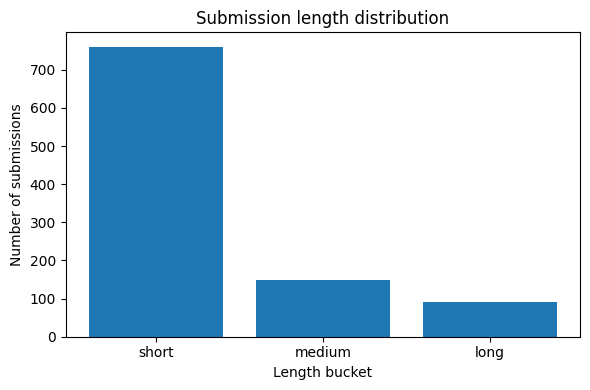

Saved plot to: /Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project/img/nlp_length_bucket_distribution.png


In [6]:
length_pdf = length_bucket_counts.toPandas()

plt.figure(figsize=(6,4))
plt.bar(length_pdf["length_bucket"], length_pdf["count"])
plt.title("Submission length distribution")
plt.xlabel("Length bucket")
plt.ylabel("Number of submissions")
plt.tight_layout()

plot_path = IMG_DIR / "nlp_length_bucket_distribution.png"
plt.savefig(plot_path, dpi=150)
plt.show()

print("Saved plot to:", plot_path)

In [7]:
# Economic / cost-of-living-ish keywords
housing_pattern = r"(?i)(rent|mortgage|landlord|lease|apartment|housing|roommate|eviction|hoa)"
jobs_income_pattern = r"(?i)(salary|wage|paycheck|bonus|promotion|job|unemployment|offer|internship|raise|income)"

submissions_sdf = (
    submissions_sdf
    .withColumn(
        "is_housing_post",
        F.when(F.col("text").rlike(housing_pattern), F.lit(1)).otherwise(F.lit(0))
    )
    .withColumn(
        "is_jobs_income_post",
        F.when(F.col("text").rlike(jobs_income_pattern), F.lit(1)).otherwise(F.lit(0))
    )
)

topic_counts = (
    submissions_sdf
    .agg(
        F.sum("is_housing_post").alias("housing_posts"),
        F.sum("is_jobs_income_post").alias("jobs_income_posts"),
    )
)

topic_counts.show()

submissions_sdf.select("subreddit", "title", "is_housing_post", "is_jobs_income_post") \
    .where((F.col("is_housing_post") == 1) | (F.col("is_jobs_income_post") == 1)) \
    .show(10, truncate=80)

+-------------+-----------------+
|housing_posts|jobs_income_posts|
+-------------+-----------------+
|           80|               59|
+-------------+-----------------+

+--------------------+--------------------------------------------------------------------------------+---------------+-------------------+
|           subreddit|                                                                           title|is_housing_post|is_jobs_income_post|
+--------------------+--------------------------------------------------------------------------------+---------------+-------------------+
|                NULL|What if an app could manage your business for you and earn new streams of inc...|              0|                  1|
|RocketLeagueExchange|                     [ps4] [H] animus, 4 nitro, 4 turbo, 1 ODC [W] 2k or offers!|              0|                  1|
|GlobalOffensiveTrade|                                                 [H] Gut Knife | Vanilla [W] 25k|              0|          

In [8]:
# We limit to a manageable sample for development (e.g., 2000 rows max)
nlp_input_sdf = submissions_sdf.limit(2000).cache()
print("NLP subset rows:", nlp_input_sdf.count())

# 1. DocumentAssembler
document_assembler = (
    DocumentAssembler()
    .setInputCol("text")
    .setOutputCol("document")
)

# 2. Tokenizer
tokenizer = (
    Tokenizer()
    .setInputCols(["document"])
    .setOutputCol("token")
)

# 3. Normalizer – lowercase, remove punctuation
normalizer = (
    Normalizer()
    .setInputCols(["token"])
    .setOutputCol("normalized")
    .setLowercase(True)
    .setCleanupPatterns(["[^a-zA-Z0-9]"])  # keep alphanumerics
)

# 4. Lemmatizer (pretrained)
lemmatizer = (
    LemmatizerModel.pretrained("lemma_antbnc", "en")
    .setInputCols(["normalized"])
    .setOutputCol("lemma")
)

# 5. StopWordsCleaner (pretrained)
stopwords_cleaner = (
    StopWordsCleaner.pretrained("stopwords_en", "en")
    .setInputCols(["lemma"])
    .setOutputCol("clean_lemma")
    .setCaseSensitive(False)
)

# 6. Stemmer
stemmer = (
    Stemmer()
    .setInputCols(["clean_lemma"])
    .setOutputCol("stem")
)

# 7. Finisher to bring tokens back as arrays of strings
finisher = (
    Finisher()
    .setInputCols(["stem"])
    .setOutputCols(["final_tokens"])
    .setIncludeMetadata(False)
)

from sparknlp.base import Pipeline

nlp_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        stemmer,
        finisher,
    ]
)

nlp_model = nlp_pipeline.fit(nlp_input_sdf)
nlp_result_sdf = nlp_model.transform(nlp_input_sdf)

nlp_result_sdf.select("subreddit", "title", "final_tokens").show(5, truncate=80)

NLP subset rows: 1000
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]

25/11/14 19:23:56 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/11/14 19:23:56 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]

25/11/14 19:23:58 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/11/14 19:23:59 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/11/14 19:23:59 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.


25/11/14 19:24:00 WARN StopWordsCleaner: Default locale set was [zh_US_#Hans]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


[OK!]


+--------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|           subreddit|                                                                           title|                                                                    final_tokens|
+--------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                NULL|What if an app could manage your business for you and earn new streams of inc...|                                         [app, manag, busi, earn, stream, incom]|
|     PUBATTLEGROUNDS|                                                        Just swiming and chillin|                                                                [swime, chillin]|
|         CFBOffTopic|                        Thursday night thread present

In [9]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.functions import vector_to_array

# ------------------------------------------------------------------
# TF-IDF style "important words" (on the 2,000-row NLP sample)
# ------------------------------------------------------------------

# 1) CountVectorizer on final_tokens
cv = CountVectorizer(
    inputCol="final_tokens",
    outputCol="raw_features",
    vocabSize=5000,
    minDF=5         # lower this if you get very few tokens
)

cv_model = cv.fit(nlp_result_sdf)
cv_df = cv_model.transform(nlp_result_sdf)

# 2) IDF on the raw term frequency features
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(cv_df)
tfidf_df = idf_model.transform(cv_df)

# 3) Convert SparseVector -> array so we can explode it
tfidf_array_df = tfidf_df.select(
    vector_to_array("tfidf_features").alias("tfidf_array")
)

# 4) Long format: (term_index, tfidf_value), summed over docs
tfidf_long = (
    tfidf_array_df
    .select(F.posexplode("tfidf_array").alias("term_index", "tfidf_value"))
    .groupBy("term_index")
    .agg(F.sum("tfidf_value").alias("tfidf_sum"))
)

# 5) Map indices back to actual terms using the vocabulary
vocab = cv_model.vocabulary

tfidf_top = (
    tfidf_long
    .orderBy(F.desc("tfidf_sum"))
    .limit(30)
    .toPandas()
)

tfidf_top["term"] = tfidf_top["term_index"].apply(lambda i: vocab[i])
tfidf_top = tfidf_top[["term", "tfidf_sum"]]

print("Top 30 'important' terms by TF-IDF sum across sample:")
display(tfidf_top)

Top 30 'important' terms by TF-IDF sum across sample:


,term,tfidf_sum
0,im,374.425584
1,game,307.766901
2,time,284.647770
3,delet,281.911654
4,plai,278.049333
5,good,267.253565
6,make,260.576777
7,dont,255.047613
8,remov,229.049858
9,feel,215.897129


In [10]:
reddit_2000 = (
    nlp_result_sdf
    .select(
        "id",
        "subreddit",
        "created_utc",
        "title",
        "selftext",
        "text",
        "final_tokens",
        "text_len_chars",
        "text_len_words",
        "length_bucket",
        "is_housing_post",
        "is_jobs_income_post",
    )
    .limit(2000)
    .cache()
)

print("Schema for reddit_2000:")
reddit_2000.printSchema()
print("Rows in reddit_2000:", reddit_2000.count())

reddit_2000.select("subreddit", "text", "final_tokens").show(5, truncate=80)

Schema for reddit_2000:
root
 |-- id: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- text: string (nullable = false)
 |-- final_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- text_len_chars: integer (nullable = false)
 |-- text_len_words: integer (nullable = false)
 |-- length_bucket: string (nullable = false)
 |-- is_housing_post: integer (nullable = false)
 |-- is_jobs_income_post: integer (nullable = false)

Rows in reddit_2000: 1000
+--------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|           subreddit|                                                                            text|                                                                    final_tokens|
+--------

Top 20 most frequent cleaned tokens in reddit_2000:


,token,count
0,im,159
1,delet,148
2,game,110
3,time,107
4,good,101
5,remov,99
6,make,99
7,dont,89
8,plai,85
9,peopl,73


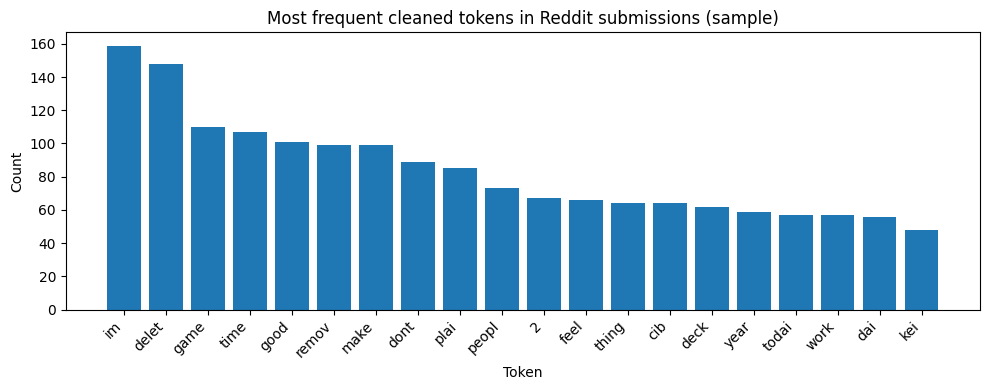

In [11]:
token_counts = (
    reddit_2000
    .select(F.explode("final_tokens").alias("token"))
    .groupBy("token")
    .count()
    .orderBy(F.desc("count"))
)

top20_tokens = token_counts.limit(20).toPandas()

print("Top 20 most frequent cleaned tokens in reddit_2000:")
display(top20_tokens)

# 3) Bar chart of top 20 tokens
plt.figure(figsize=(10, 4))
plt.bar(top20_tokens["token"], top20_tokens["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Most frequent cleaned tokens in Reddit submissions (sample)")
plt.xlabel("Token")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [12]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, ViveknSentimentModel
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

# === Build a lightweight sentiment pipeline using Vivekn (no TensorFlow) ===

# 1) Input text for sentiment: use the combined "text" field from reddit_2000
# NOTE: reddit_2000 currently has: id, subreddit, created_utc, title, selftext, text, ...
sentiment_input = (
    reddit_2000
    .select("id", "subreddit", "created_utc", "text")
    .where(F.col("text").isNotNull())
)

print("Rows available for sentiment analysis:", sentiment_input.count())

# 2) Document + token stages (simple, fresh pipeline for sentiment)
sent_document = (
    DocumentAssembler()
    .setInputCol("text")
    .setOutputCol("sent_document")
)

sent_tokenizer = (
    Tokenizer()
    .setInputCols(["sent_document"])
    .setOutputCol("sent_token")
)

# 3) Pre-trained Vivekn sentiment model (no TensorFlow dependency)
sentiment_vivekn = (
    ViveknSentimentModel.pretrained("sentiment_vivekn", "en")
    .setInputCols(["sent_document", "sent_token"])
    .setOutputCol("sentiment")
)

sentiment_pipeline = Pipeline(stages=[sent_document, sent_tokenizer, sentiment_vivekn])

# Fit on a small sample (fit is almost a no-op for pretrained model)
sentiment_model = sentiment_pipeline.fit(sentiment_input)

# Transform the full sentiment_input (still small: reddit_2000)
sentiment_result = sentiment_model.transform(sentiment_input).cache()

sentiment_result.select("id", "text", "sentiment").show(5, truncate=80)

Rows available for sentiment analysis: 1000
sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[ | ]

25/11/14 19:24:27 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/11/14 19:24:27 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/11/14 19:24:27 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
Download done! Loading the resource.
[OK!]
+------+--------------------------------------------------------------------------------+-----------------------------------------------------------+
|    id|                                                                            text|                                                  sentiment|
+------+--------------------------------------------------------------------------------+-----------------------------------------------------------+
|6xauxl|What if an app could manage your business for you and earn new streams of inc...|[{sentiment, 0, 109, positive, {confidence -> 0.5681}, []}]|
|6xauxm|                                                       Just swiming and chillin | [{sentiment, 0, 23, negative, {confidence -> 0.6235}, []}]|
|6xauxn|                       Thursday night thread presented by NFL preseason week 4. | [{sentiment, 0, 55, 

In [13]:
# === Summaries: how many positive / negative posts? ===

sentiment_counts = (
    sentiment_result
    .select(F.explode("sentiment.result").alias("sentiment_label"))
    .groupBy("sentiment_label")
    .count()
    .orderBy(F.desc("count"))
)

sentiment_counts_df = sentiment_counts.toPandas()
print("Sentiment label distribution (Vivekn model):")
display(sentiment_counts_df)

Sentiment label distribution (Vivekn model):


,sentiment_label,count
0,negative,531
1,positive,395
2,na,74
